# Livrable 3 – Image Captioning

**Objectif :** Construire un modèle CNN–RNN avec attention pour générer des légendes sur MS COCO.

Le réseau est composé de :
- Un **encodeur CNN** (InceptionV3 pré‑entraîné) qui transforme l’image en représentations visuelles,
- Un **décodeur RNN** (GRU + Attention) qui génère la légende mot à mot.

In [3]:
import os, json, collections
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras import Model
import matplotlib.pyplot as plt

BASE_DIR       = os.getcwd()
COCO_DIR       = os.path.join(BASE_DIR, 'datasets', 'coco')
ANN_DIR        = os.path.join(COCO_DIR, 'annotations')
IMG_TRAIN_DIR  = os.path.join(COCO_DIR, 'images', 'train2014')
IMG_VAL_DIR    = os.path.join(COCO_DIR, 'images', 'val2014')

BATCH_SIZE   = 64
BUFFER_SIZE  = 1000
EMBED_DIM    = 256
UNITS        = 512
VOCAB_SIZE   = 5000
MAX_LENGTH   = 50
EPOCHS       = 20
FEATURE_SHAPE = 64

In [4]:
# Cellule 2 – Chargement des annotations COCO et mapping
with open(os.path.join(ANN_DIR, 'captions_train2014.json'), 'r') as f:
    ann = json.load(f)

# image_id → nom de fichier
id2file = {img['id']: img['file_name'] for img in ann['images']}

# Regrouper les captions par chemin complet
cap_dict = collections.defaultdict(list)
for a in ann['annotations']:
    fname = id2file[a['image_id']]
    path  = os.path.join(IMG_TRAIN_DIR, fname)
    cap   = '<start> ' + a['caption'].lower().strip() + ' <end>'
    cap_dict[path].append(cap)

# Listes finales
all_image_paths = list(cap_dict.keys())
all_captions    = [c for caps in cap_dict.values() for c in caps]

print(f"{len(all_image_paths)} images, {len(all_captions)} captions")

82783 images, 414113 captions


In [24]:
# --- Limitation pour debug : on ne prend que 10 000 images ---
selected_image_paths = all_image_paths[:10000]

# On recrée cap_dict uniquement pour ces images
cap_dict = {path: cap_dict[path] for path in selected_image_paths}

# Mettre à jour all_image_paths et all_captions si besoin
all_image_paths = selected_image_paths
all_captions    = [c for caps in cap_dict.values() for c in caps]

print("→ Nombre d'images pour le test :", len(all_image_paths))
print("→ Nombre de captions associées :", len(all_captions))

→ Nombre d'images pour le test : 10000
→ Nombre de captions associées : 50020


In [25]:
# Cellule 3 – Tokenizer et préparation des séquences de légendes
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    oov_token='<unk>',
    filters='!"#$%&()*+.,-/:;?@[\]^_`{|}~ '
)
tokenizer.fit_on_texts(all_captions)

# Réserver l'indice 0 pour <pad>
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0]   = '<pad>'

# Conversion des légendes en séquences d'indices et padding
cap_seqs = tokenizer.texts_to_sequences(all_captions)
cap_seqs = pad_sequences(cap_seqs, maxlen=MAX_LENGTH, padding='post')

print("Exemple :", all_captions[0], "→", cap_seqs[0])

Exemple : <start> a very clean and well decorated empty bathroom <end> → [  3   2  85 121   7 385 270 157  11   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [26]:
# Cellule 4 – Extraction des features visuelles avec InceptionV3

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import Model
from tqdm import tqdm

# 1) Charger InceptionV3 pré‑entraîné sans la tête de classification
image_model = InceptionV3(include_top=False, weights='imagenet')
new_input = tf.keras.Input(shape=(299, 299, 3))
hidden_layer = image_model(new_input)  # sortie : (batch, 8, 8, 2048)
feat_extract_model = Model(inputs=new_input, outputs=hidden_layer)

# 2) Fonction de chargement et pré‑traitement d'une image
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, path

# 3) Création du dataset d'images pré‑traitées
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = image_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
image_ds = image_ds.batch(BATCH_SIZE)

# 4) Extraction et sauvegarde des représentations
for img_batch, path_batch in tqdm(image_ds):
    # Extraction features : (bs, 8,8,2048) → reshape (bs, 64, 2048)
    batch_features = feat_extract_model(img_batch)
    batch_features = tf.reshape(batch_features, 
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    # Sauvegarde .npy pour chaque image
    for bf, p in zip(batch_features, path_batch.numpy()):
        np.save(p.decode('utf-8'), bf.numpy())

100%|██████████| 157/157 [01:11<00:00,  2.19it/s]


In [27]:
# Cellule 5 – Préparation du tf.data.Dataset pour l’entraînement

import numpy as np

def map_func(img_path, cap):
    img_tensor = np.load(img_path.decode('utf-8') + '.npy')
    return img_tensor, cap

# 1) Construire listes de chemins et séquences de captions
img_name_vector = []
cap_vector      = []

for img_path, caps in cap_dict.items():
    img_name_vector.extend([img_path] * len(caps))
    cap_vector.extend(caps)

# 2) Convertir les captions en séquences et appliquer le padding
cap_seqs = tokenizer.texts_to_sequences(cap_vector)
cap_seqs = pad_sequences(cap_seqs, maxlen=MAX_LENGTH, padding='post')

# 3) Créer et optimiser le tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((img_name_vector, cap_seqs))
dataset = dataset.map(
    lambda x, y: tf.numpy_function(map_func, [x, y], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

print("Dataset prêt :", dataset)

Dataset prêt : <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>


In [29]:
# Cellule 6 (bis) – Encoder, Attention & Decoder avec GRU unrolled

from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras import Model
import tensorflow as tf

class CNN_Encoder(Model):
    def __init__(self, embed_dim):
        super().__init__()
        self.fc = Dense(embed_dim)
    def call(self, x):
        return tf.nn.relu(self.fc(x))  # (batch, 64, embed_dim)

class BahdanauAttention(Model):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V  = Dense(1)
    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)                      # (batch,1,units)
        score       = tf.nn.tanh(self.W1(features) + self.W2(hidden_time))
        weights     = tf.nn.softmax(self.V(score), axis=1)           # (batch,64,1)
        context     = tf.reduce_sum(weights * features, axis=1)      # (batch,units)
        return context, weights

class RNN_Decoder(Model):
    def __init__(self, vocab_size, embed_dim, units):
        super().__init__()
        self.units     = units
        self.embedding = Embedding(vocab_size, embed_dim)
        # on force l'unrolling pour éviter le mask
        self.gru       = GRU(units,
                             return_sequences=True,
                             return_state=True,
                             recurrent_initializer='glorot_uniform',
                             unroll=True)
        self.fc1       = Dense(units)
        self.fc2       = Dense(vocab_size)
        self.attention = BahdanauAttention(units)

    def call(self, x, features, hidden):
        # calcul de l'attention
        context, att_w = self.attention(features, hidden)            # (batch,units)
        x = self.embedding(x)                                        # (batch,1,embed_dim)
        x = tf.concat([tf.expand_dims(context,1), x], axis=-1)       # (batch,1,embed_dim+units)
        # ici plus de mask, grâce à unroll=True
        output, state = self.gru(x, initial_state=hidden)            # (batch,1,units), (batch,units)
        x = self.fc1(output)                                         # (batch,1,units)
        x = tf.reshape(x, (-1, x.shape[2]))                          # (batch,units)
        x = self.fc2(x)                                              # (batch,vocab_size)
        return x, state, att_w

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

# (Re)instanciation
encoder     = CNN_Encoder(EMBED_DIM)
decoder     = RNN_Decoder(VOCAB_SIZE, EMBED_DIM, UNITS)
optimizer   = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_ * tf.cast(mask, loss_.dtype))

In [30]:
# Cellule 7 – Entraînement du modèle (version sans @tf.function pour éviter l’OperatorNotAllowedInGraphError)

def train_step(img_tensor, target):
    loss = 0.0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    # initialisation du token <start>
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * target.shape[0], axis=1
    )
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)  # (batch, 64, embed_dim)
        for i in range(1, target.shape[1]):
            # on passe training=True pour la GRU
            predictions, hidden, _ = decoder(dec_input, features, hidden, training=True)
            loss += loss_function(target[:, i], predictions)
            # teacher forcing
            dec_input = tf.expand_dims(target[:, i], axis=1)
    total_loss = loss / int(target.shape[1])
    # gradients et optimisation
    train_vars = encoder.trainable_variables + decoder.trainable_variables
    grads      = tape.gradient(loss, train_vars)
    optimizer.apply_gradients(zip(grads, train_vars))
    return total_loss

from tqdm import  

for epoch in range(EPOCHS):
    total_loss = 0.0
    for img_tensor, target in tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch_loss = train_step(img_tensor, target)
        total_loss += batch_loss
    epoch_loss = total_loss / dataset.cardinality().numpy()
    print(f"Epoch {epoch+1}, Loss moyenne : {epoch_loss:.4f}")

Epoch 1/20: 100%|██████████| 782/782 [14:34<00:00,  1.12s/it]


Epoch 1, Loss moyenne : 0.8059


Epoch 2/20: 100%|██████████| 782/782 [14:18<00:00,  1.10s/it]


Epoch 2, Loss moyenne : 0.6308


Epoch 3/20: 100%|██████████| 782/782 [39:24<00:00,  3.02s/it]


Epoch 3, Loss moyenne : 0.5679


Epoch 4/20: 100%|██████████| 782/782 [40:54<00:00,  3.14s/it]


Epoch 4, Loss moyenne : 0.5233


Epoch 5/20: 100%|██████████| 782/782 [13:52<00:00,  1.06s/it]


Epoch 5, Loss moyenne : 0.4836


Epoch 6/20: 100%|██████████| 782/782 [13:35<00:00,  1.04s/it]


Epoch 6, Loss moyenne : 0.4454


Epoch 7/20: 100%|██████████| 782/782 [13:43<00:00,  1.05s/it]


Epoch 7, Loss moyenne : 0.4089


Epoch 8/20: 100%|██████████| 782/782 [13:27<00:00,  1.03s/it]


Epoch 8, Loss moyenne : 0.3750


Epoch 9/20: 100%|██████████| 782/782 [13:59<00:00,  1.07s/it]


Epoch 9, Loss moyenne : 0.3437


Epoch 10/20: 100%|██████████| 782/782 [13:56<00:00,  1.07s/it]


Epoch 10, Loss moyenne : 0.3148


Epoch 11/20: 100%|██████████| 782/782 [13:58<00:00,  1.07s/it]


Epoch 11, Loss moyenne : 0.2897


Epoch 12/20: 100%|██████████| 782/782 [14:16<00:00,  1.09s/it]


Epoch 12, Loss moyenne : 0.2673


Epoch 13/20: 100%|██████████| 782/782 [13:56<00:00,  1.07s/it]


Epoch 13, Loss moyenne : 0.2490


Epoch 14/20: 100%|██████████| 782/782 [14:00<00:00,  1.07s/it]


Epoch 14, Loss moyenne : 0.2329


Epoch 15/20: 100%|██████████| 782/782 [14:15<00:00,  1.09s/it]


Epoch 15, Loss moyenne : 0.2191


Epoch 16/20: 100%|██████████| 782/782 [13:23<00:00,  1.03s/it]


Epoch 16, Loss moyenne : 0.2073


Epoch 17/20: 100%|██████████| 782/782 [13:44<00:00,  1.05s/it]


Epoch 17, Loss moyenne : 0.1971


Epoch 18/20: 100%|██████████| 782/782 [34:09<00:00,  2.62s/it]


Epoch 18, Loss moyenne : 0.1880


Epoch 19/20: 100%|██████████| 782/782 [14:31<00:00,  1.11s/it]


Epoch 19, Loss moyenne : 0.1805


Epoch 20/20: 100%|██████████| 782/782 [15:25<00:00,  1.18s/it]

Epoch 20, Loss moyenne : 0.1743


In [34]:
# Cellule 9 – Sauvegarde finale des poids (HDF5) et du tokenizer

import pickle

# 1) Sauvegarde des poids
encoder.save_weights('encoder.weights.h5')
decoder.save_weights('decoder.weights.h5')
print("✅ Poids enregistrés : encoder_weights.h5, decoder_weights.h5")

# 2) (Optionnel) Sauvegarde du tokenizer pour l’inférence ultérieure
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer enregistré : tokenizer.pkl")

✅ Poids enregistrés : encoder_weights.h5, decoder_weights.h5
✅ Tokenizer enregistré : tokenizer.pkl


Prédiction : a man riding a motorcycle in the middle of the ocean


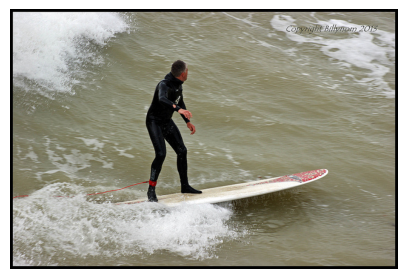

Prédiction : a bowl of <unk> with two laptops on it


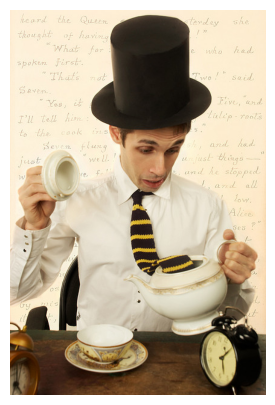

Prédiction : a group of transit buses crossing the street


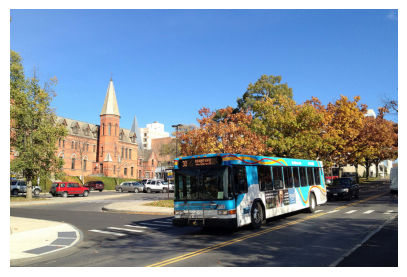

Prédiction : a dog is looking at a dog on a leash


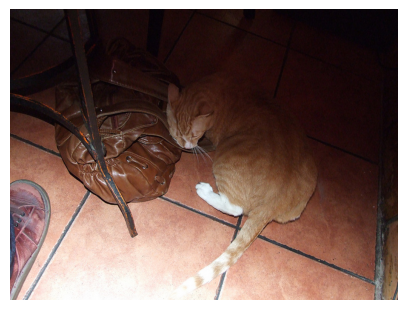

Prédiction : a white toilet sitting in a bathroom next to a wall


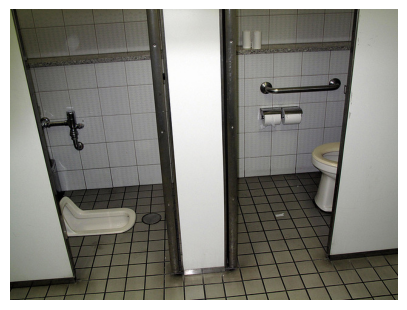

In [37]:
# Cellule 11 – Évaluation et affichage des prédictions

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob

# Sélection de quelques images de validation
val_image_paths = glob(os.path.join(IMG_VAL_DIR, '*.jpg'))[:5]

def evaluate(image_path):
    # Pré‑traitement
    img, _ = load_image(image_path)
    img = tf.expand_dims(img, 0)
    # Extraction des features
    features = feat_extract_model(img)                                  # (1,8,8,2048)
    features = tf.reshape(features, (1, -1, features.shape[3]))       # (1,64,2048)
    features = encoder(features)                                       # (1,64,embed_dim)
    # Décodage séquentiel
    hidden = decoder.reset_state(batch_size=1)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(MAX_LENGTH):
        predictions, hidden, _ = decoder(dec_input, features, hidden, training=False)
        predicted_id = tf.argmax(predictions[0]).numpy()
        word = tokenizer.index_word.get(predicted_id, '<unk>')
        if word == '<end>':
            break
        result.append(word)
        dec_input = tf.expand_dims([predicted_id], 0)
    return ' '.join(result)

# Affichage des images et des légendes générées
for img_path in val_image_paths:
    plt.figure(figsize=(5,5))
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    print("Prédiction :", evaluate(img_path))
    plt.show()